# Analysis for Insight Project

## Setup

In [1]:
# import modules
import pandas as pd
import numpy as np
import rootpath
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import sklearn.metrics as metrics
import qgrid
import matplotlib.pyplot as plt

# Set root path for project
path = rootpath.detect()

# Read in data
# Use list comprehension to read in all files
df = pd.read_csv(f"{path}/data/data_clean.csv", index_col=0).reset_index(drop=True)

In [ ]:
# Product type validation
df = pd.read_csv(f"{path}/data/data_clean_prodtype_valid.csv", index_col=0).reset_index(drop=True)

In [564]:
df[df['brand']=="SUNDAY RILEY"]

,product,brand,product_type,active,price,size,ratings,total_reviews,link,price_oz,0,1
243,Ceramic Slip Cleanser,SUNDAY RILEY,face wash,no_actives,35.0,5.00,3.2,33,https://www.ulta.com/ceramic-slip-cleanser?pro...,7.00,-14.211832,15.635860
295,Pink Drink Firming Resurfacing Essence,SUNDAY RILEY,toner,no_actives,48.0,6.75,5.0,2,https://www.ulta.com/pink-drink-firming-resurf...,7.11,-0.233837,-17.874914
865,Good Genes All-In-One Lactic Acid Treatment,SUNDAY RILEY,face serum,no_actives,85.0,1.00,4.1,104,https://www.ulta.com/good-genes-all-in-one-lac...,85.00,9.746774,-2.926974
866,A+ High-Dose Retinoid Serum,SUNDAY RILEY,face serum,no_actives,85.0,1.00,4.4,30,https://www.ulta.com/a-high-dose-retinoid-seru...,85.00,4.644239,-1.574981
867,C.E.O. 15% Vitamin C Brightening Serum,SUNDAY RILEY,face serum,no_actives,85.0,1.00,3.8,43,https://www.ulta.com/ceo-15-vitamin-c-brighten...,85.00,13.503988,-11.133731


In [602]:
#df.head()
df.shape

(853, 20)

In [2]:
#features = df.copy().set_index('product')
# Old, before dimensionality reduction
features = df.copy().drop(['product_type','brand', 'price','size','ratings', 'active',
                           'total_reviews','link','price_oz'],
                          axis=1).set_index('product')
#features.head()

## K-means++

#### Run K-means and determine number of clusters based on silhouette coef

In [604]:
# Set cluster arguments
kmeans_kwargs = {
        "init": "k-means++",
        "n_init": 10,
        "max_iter": 300,
        "random_state": 42,
        }

In [605]:
silhouette_coefficients = []

# Get silhouette coefficient for each cluster out of 50
for cluster in range(2, 20):
    kmeans = KMeans(n_clusters=cluster, **kmeans_kwargs)
    kmeans.fit(features)
    score = silhouette_score(features, kmeans.labels_)
    silhouette_coefficients.append(score)

#### Plot silhouette coefficients vs. clusters

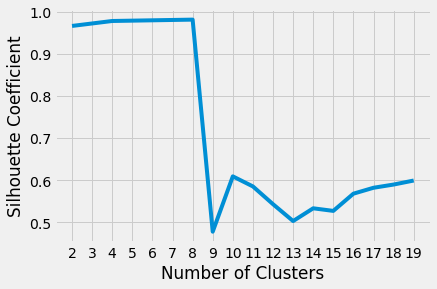

In [606]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [ ]:
# Add cluster labels to features


## DBSCAN

In [417]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [435]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(features)
distances, indices = nbrs.kneighbors(features)

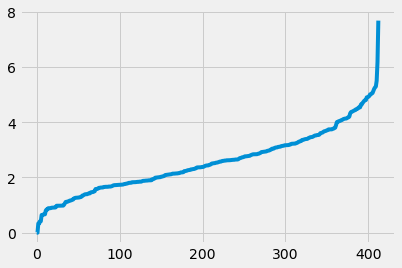

In [436]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [437]:
dbsc = DBSCAN(eps = 5, min_samples = 5).fit(features)
labels = dbsc.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(features, labels))


Estimated number of clusters: 1
Estimated number of noise points: 13
Silhouette Coefficient: 0.335


## Hierarchical/Agglomerative clustering

In [607]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

# Plot clustering results

# for index, metric in enumerate(["cosine", "euclidean", "cityblock"]):
#     model = AgglomerativeClustering(n_clusters=n_clusters,
#                                     linkage="average", affinity=metric)
#     model.fit(features)
#     plt.figure()
#     plt.axes([0, 0, 1, 1])
#     for l, c in zip(np.arange(model.n_clusters), 'rgbk'):
#         plt.plot(features[model.labels_ == l].T, c=c, alpha=.5)
#     plt.axis('tight')
#     plt.axis('off')
#     plt.suptitle("AgglomerativeClustering(affinity=%s)" % metric, size=20)


# plt.show()

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
y_hc =cluster.fit_predict(features)

#plt.scatter(features[:,1],features[:,2], c=cluster.labels_, cmap='rainbow')
# plt.scatter(features[y_hc ==0,0], features[y_hc == 0,1], s=100, c='red')
# plt.scatter(features[y_hc==1,0], features[y_hc == 1,1], s=100, c='black')
# plt.scatter(features[y_hc ==2,0], features[y_hc == 2,1], s=100, c='blue')
# plt.scatter(features[y_hc ==3,0], features[y_hc == 3,1], s=100, c='cyan')

In [584]:
features['cluster_labels'] = y_hc

In [585]:
features.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,cluster_labels
product,,,,,,,,,,,,,,,,,,,,,
The Microdelivery Exfoliating Facial Wash,1.225257,-0.831471,1.085914,0.199215,0.165847,-0.155683,0.247914,-0.088967,0.128975,-0.095547,...,0.018721,0.002497,-0.000112,0.035511,0.016232,0.056432,-0.024071,-0.001694,0.077221,0
AHA/BHA Exfoliating Cleanser,1.809298,-1.060433,0.882881,0.055500,0.234946,0.353983,-0.181930,0.219278,-0.083361,0.131203,...,0.026904,-0.050614,-0.131670,-0.038460,-0.002883,0.127456,-0.034768,0.034917,-0.037506,0
Hydrating Facial Cleanser,1.818391,-0.935320,0.792429,-0.170304,0.228655,-0.111074,-0.175043,-0.202005,-0.271360,0.301803,...,-0.209259,0.003113,-0.134940,0.051685,0.112461,0.000606,-0.011100,0.003331,0.005446,1
Anti-Aging Cleansing Gel,1.826982,-1.030466,0.869849,-0.058911,0.029676,0.357792,-0.382368,0.322961,-0.053760,-0.038201,...,-0.023535,0.036525,-0.075986,-0.044725,0.060956,-0.112853,0.073869,0.067343,-0.017364,0
Essential-C Cleanser,2.232532,-0.818987,0.772971,0.280153,0.337319,0.206010,-0.421622,0.500059,0.022538,-0.099224,...,0.192014,-0.030955,-0.227304,0.010332,-0.115268,-0.053123,-0.252086,-0.080943,-0.094681,0


In [608]:
plt.figure(figsize=(10, 7))  
plt.scatter(features['0'], features['1'], c=features['cluster_labels']) 

KeyError: 'cluster_labels'

<Figure size 720x504 with 0 Axes>

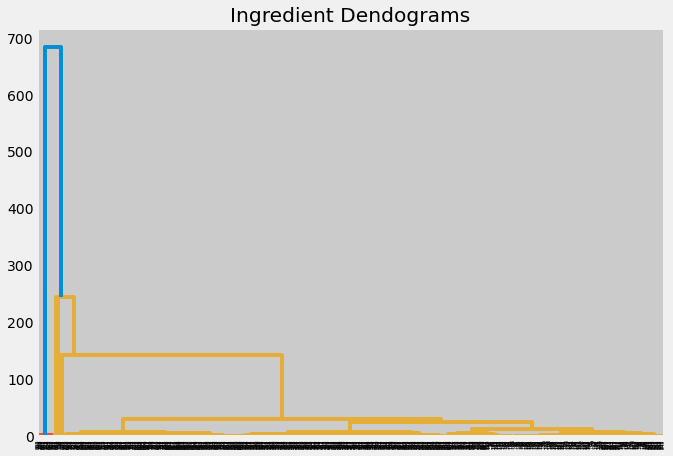

In [610]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Ingredient Dendograms")
dend = shc.dendrogram(shc.linkage(features, method='ward'))

## Gaussian Mixture models

In [457]:
from sklearn.mixture import GaussianMixture as GMM
#from sklearn.mixture import GMM
gmm = GMM(n_components=4).fit(features)
labels = gmm.predict(features)

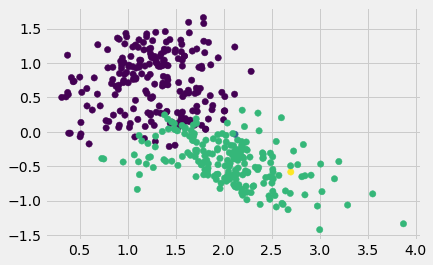

In [458]:
plt.scatter(features.iloc[:, 0], features.iloc[:, 1], c=labels, s=40, cmap='viridis')

Text(0.5, 0, 'n_components')

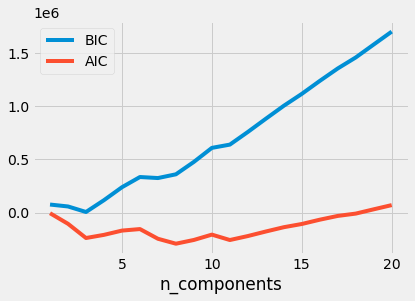

In [456]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(features)
          for n in n_components]

plt.plot(n_components, [m.bic(features) for m in models], label='BIC')
plt.plot(n_components, [m.aic(features) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

In [ ]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(features)
          for n in n_components]

plt.plot(n_components, [m.bic(features) for m in models], label='BIC')
plt.plot(n_components, [m.aic(features) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

## Pearson correlation

In [459]:
from sklearn.metrics import pairwise_distances

In [465]:
res_pearson = pairwise_distances(features.loc['Gentle Skin Cleanser',:].to_frame().transpose(), features,
                             metric='correlation') #[0:1] .loc["Essential-C Cleanser",:]
res_pearson

array([[0.6659717 , 0.65244956, 0.65833056, 0.64335864, 0.56099857,
        0.4287003 , 0.64115638, 0.65178082, 0.75585038, 0.7784969 ,
        0.37403556, 0.51420108, 0.35650727, 0.6124025 , 0.34853841,
        0.6836847 , 0.72785581, 0.87135438, 0.65260959, 0.65107936,
        0.60936829, 0.71738867, 0.67516719, 0.30237294, 0.7367131 ,
        0.5757427 , 0.61580584, 0.4609563 , 0.43872098, 0.88477554,
        0.58673214, 0.75242958, 0.67046645, 0.42054256, 0.75551712,
        0.83280832, 0.47495109, 0.61112765, 0.65054406, 0.73940975,
        0.7391732 , 0.75976675, 0.3984938 , 0.71547664, 0.68477574,
        0.60670738, 0.71578729, 0.49856663, 0.5815316 , 0.61508239,
        0.66406859, 0.65306131, 0.8609149 , 0.61111591, 0.75656364,
        0.66619389, 0.70578902, 0.71064032, 0.53261339, 0.7726461 ,
        0.27510447, 0.7075833 , 0.61365785, 0.64829463, 0.65780688,
        0.7075833 , 0.53212903, 0.74474819, 0.56340711, 0.55120436,
        0.61752173, 0.66328742, 0.68067665, 0.51

In [466]:
res_pearson = res_pearson.reshape(-1)
res_pearson = pd.DataFrame(res_pearson)
res_sim=df[['product','brand','product_type','price','size','ratings',
            'total_reviews','link','price_oz']].copy()
res_sim['similarity']=res_pearson[[0]]
# Round similarity metric
#res_sim['similarity']=round(res_sim['similarity'],2)
# Maybe don't round so you don't have to deal with ties?
#indexNames = res_sim[res_sim['product']=='Essential-C Cleanser'].index
#res_sim.drop(indexNames, inplace=True)
# Sort from top similarity metrics and ignoring self, so starting at 1, not zero
test = res_sim.nlargest(10, 'similarity')[1:10]
#res_sim.head()
# Select top match
test#[:1]

,product,brand,product_type,price,size,ratings,total_reviews,link,price_oz,similarity
150,Resveratrol 3% + Ferulic Acid 3%,The Ordinary,face serum,7.9,1.00,4.5,44.0,https://www.ulta.com/resveratrol-3-ferulic-aci...,7.90,1.014276
252,Royal Honey Propolis Enrich Essence,Skinfood,face moisturizer,39.0,1.69,4.6,11.0,https://www.ulta.com/royal-honey-propolis-enri...,23.08,1.010068
129,Hydrating Mist,Juice Beauty,toner,25.0,6.75,3.7,107.0,https://www.ulta.com/hydrating-mist?productId=...,3.70,1.007389
217,Propolis Light Ampule,COSRX,face serum,28.0,1.01,4.4,44.0,https://www.ulta.com/propolis-light-ampule?pro...,27.72,1.005124
154,Advanced Snail 96 Mucin Power Essence,COSRX,face serum,23.0,3.38,4.6,326.0,https://www.ulta.com/advanced-snail-96-mucin-p...,6.80,1.005072
178,Organic Face Serum With Coffee Oil,UpCircle,face serum,20.0,1.00,4.8,494.0,https://www.ulta.com/organic-face-serum-with-c...,20.00,1.003593
146,Turbo Booster C Powder,Philosophy,face serum,39.0,0.25,4.6,178.0,https://www.ulta.com/turbo-booster-c-powder?pr...,156.00,1.002300
153,Future Youth Crystal Ball Serum,Pacifica,face serum,16.0,0.60,4.5,61.0,https://www.ulta.com/future-youth-crystal-ball...,26.67,1.000024
203,Maracuja Oil,Tarte,face serum,48.0,1.70,4.5,1151.0,https://www.ulta.com/maracuja-oil?productId=xl...,28.24,0.999104


## Euclidean similarity

In [467]:
from sklearn.metrics import pairwise_distances
import heapq as hq

In [479]:
res_euc = pairwise_distances(features.loc['Gentle Skin Cleanser',:].to_frame().transpose(), features,
                             metric='euclidean') #[0:1] .loc["Essential-C Cleanser",:]
res_euc

array([[2.51678287, 2.33142432, 2.42849237, 2.3516415 , 2.74855314,
        1.95716933, 2.74452158, 2.89868572, 3.9829232 , 4.29047748,
        1.73297626, 2.42100615, 1.75963736, 2.19047426, 1.84817541,
        3.14575898, 3.51311736, 3.95159575, 2.37246507, 2.36048906,
        2.52256884, 3.45346666, 2.50148726, 1.64919185, 3.63089822,
        2.30893004, 2.65989352, 2.06113448, 1.94171032, 3.97566301,
        2.37263984, 3.82783308, 2.97006306, 1.89642226, 3.99874796,
        3.21055362, 2.4302471 , 2.57463623, 2.29409136, 3.89521447,
        2.39991795, 4.0063986 , 1.82504003, 3.36528216, 3.10630097,
        2.23136259, 3.36952555, 2.29178832, 3.19704216, 2.63099639,
        4.07027635, 3.17384605, 3.65512622, 2.56129209, 3.96560206,
        2.62396166, 4.76051565, 3.34166219, 2.82192039, 4.17852233,
        1.50150605, 3.3618171 , 2.56968273, 2.35973142, 3.7541872 ,
        3.3618171 , 2.15081486, 3.78289062, 2.31771648, 2.93331729,
        2.79883039, 2.93085612, 3.05639757, 2.68

In [480]:
res_euc = res_euc.reshape(-1)
res_euc = pd.DataFrame(res_euc)
res_sim=df[['product','brand','product_type','price','size','ratings',
            'total_reviews','link','price_oz']].copy()
res_sim['similarity']=res_euc[[0]]
# Round similarity metric
#res_sim['similarity']=round(res_sim['similarity'],2)
# Maybe don't round so you don't have to deal with ties?
#indexNames = res_sim[res_sim['product']=='Essential-C Cleanser'].index
#res_sim.drop(indexNames, inplace=True)
# Sort from top similarity metrics and ignoring self, so starting at 1, not zero
test = res_sim.nsmallest(10, 'similarity')[1:10]
#res_sim.head()
# Select top match
test#[:1]

,product,brand,product_type,price,size,ratings,total_reviews,link,price_oz,similarity
60,Vital Vita 12 Jelly Cleanser,TONYMOLY,face wash,18.00,5.0,4.2,15.0,https://www.ulta.com/vital-vita-12-jelly-clean...,3.60,1.501506
111,Foaming Facial Wash,Curél,face wash,20.00,5.0,4.6,240.0,https://www.ulta.com/foaming-facial-wash?produ...,4.00,1.636158
23,Orange Cleansing Soap,Mario Badescu,face wash,12.00,8.0,4.0,159.0,https://www.ulta.com/orange-cleansing-soap?pro...,1.50,1.649192
87,SkinActive Micellar Cleansing Water All-in-1 C...,Garnier,face wash,4.99,3.3,4.3,1726.0,https://www.ulta.com/skinactive-micellar-clean...,1.51,1.705777
99,AHA/BHA Acne Clearing Gel,Peter Thomas Roth,face wash,54.00,3.4,4.3,77.0,https://www.ulta.com/ahabha-acne-clearing-gel?...,15.88,1.726108
10,SkinActive Micellar Cleansing Water with Rose ...,Garnier,face wash,8.99,13.5,4.7,679.0,https://www.ulta.com/skinactive-micellar-clean...,0.67,1.732976
12,Oil-Free Acne Wash Pink Grapefruit Facial Clea...,Neutrogena,face wash,9.99,6.0,4.0,2646.0,https://www.ulta.com/oil-free-acne-wash-pink-g...,1.66,1.759637
42,All Bright Cleansing Foam Wash,Botanics,face wash,6.99,5.0,4.2,218.0,https://www.ulta.com/all-bright-cleansing-foam...,1.40,1.825040
14,Chamomile Cleansing Lotion,Mario Badescu,face wash,15.00,8.0,3.9,13.0,https://www.ulta.com/chamomile-cleansing-lotio...,1.88,1.848175


## Cosine similarity

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
import heapq as hq

In [556]:
features.loc['Good Genes All-In-One Lactic Acid Treatment',:].to_frame().transpose()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Good Genes All-In-One Lactic Acid Treatment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Calculate cosine similarity for feature 1 
res_cosine = cosine_similarity(features.loc['A+ High-Dose Retinoid Serum',:].to_frame().transpose(), features) #[0:1] .loc["Essential-C Cleanser",:]
res_cosine = res_cosine.reshape(-1)
res_cosine = pd.DataFrame(res_cosine)
res_sim=df[['product','brand','product_type','price','size','ratings', 'active',
            'total_reviews','link','price_oz']].copy()
res_sim['similarity']=res_cosine[[0]]
# Round similarity metric
#res_sim['similarity']=round(res_sim['similarity'],2)
# Maybe don't round so you don't have to deal with ties?
#indexNames = res_sim[res_sim['product']=='Essential-C Cleanser'].index
#res_sim.drop(indexNames, inplace=True)
# Sort from top similarity metrics and ignoring self, so starting at 1, not zero
test = res_sim.nlargest(10, 'similarity')[1:10]
#res_sim.head()
# Select top match
test#[:1]
#Good Genes All-In-One Lactic Acid Treatment


,product,brand,product_type,price,size,ratings,active,total_reviews,link,price_oz,similarity
852,C.E.O. 15% Vitamin C Brightening Serum,SUNDAY RILEY,face serum,85.00,1.00,3.8,no_actives,43,https://www.ulta.com/ceo-15-vitamin-c-brighten...,85.00,0.997055
543,Multi Correxion Revive + Glow Daily Serum,RoC,face serum,32.99,1.00,4.8,no_actives,97,https://www.ulta.com/multi-correxion-revive-gl...,32.99,0.982840
539,Quench Hydrating Face Serum,Kate Somerville,face serum,75.00,1.00,4.8,no_actives,226,https://www.ulta.com/quench-hydrating-face-ser...,75.00,0.982089
566,Peptight Tightening & Brightening Face Serum,StriVectin,face serum,99.00,1.70,4.5,no_actives,136,https://www.ulta.com/peptight-tightening-brigh...,58.24,0.980256
541,Midnight Recovery Concentrate,Kiehl's Since 1851,face serum,52.00,1.00,4.6,no_actives,885,https://www.ulta.com/midnight-recovery-concent...,52.00,0.979933
549,Hydra Sebum Control Essence,belif,face serum,42.00,1.68,5.0,no_actives,2,https://www.ulta.com/hydra-sebum-control-essen...,25.00,0.979284
850,Good Genes All-In-One Lactic Acid Treatment,SUNDAY RILEY,face serum,85.00,1.00,4.1,no_actives,104,https://www.ulta.com/good-genes-all-in-one-lac...,85.00,0.979164
544,Peptide4 Antioxidant Hydra Serum,ELEMIS,face serum,72.00,1.00,4.9,no_actives,8,https://www.ulta.com/peptide4-antioxidant-hydr...,72.00,0.978991
535,Radically Rejuvenating Dual Phase Bakuchiol Serum,ACURE,face serum,19.99,0.60,4.3,no_actives,7,https://www.ulta.com/radically-rejuvenating-du...,33.32,0.977710


In [554]:
res_sim.columns

Index(['product', 'brand', 'product_type', 'price', 'size', 'ratings',
       'active', 'total_reviews', 'link', 'price_oz', 'similarity'],
      dtype='object')

In [29]:
res_cosine = cosine_similarity(features.loc['A+ High-Dose Retinoid Serum',:].to_frame().transpose(), features) #[0:1] .loc["Essential-C Cleanser",:]
res_cosine = res_cosine.reshape(-1)
res_cosine = pd.DataFrame(res_cosine)
res_sim=df[['product','brand','product_type','price','size','ratings', 'active',
            'total_reviews','link','price_oz']].copy()
res_sim['similarity']=res_cosine[[0]]
# Round similarity metric
#res_sim['similarity']=round(res_sim['similarity'],2)
# Maybe don't round so you don't have to deal with ties?

# Sort from top similarity metrics and ignoring self, so starting at 1, not zero
test = res_sim.nlargest(6, 'similarity')[0:6]
#res_sim.head()
# Select top match
test['product_type']#.loc[test['product']=='A+ High-Dose Retinoid Serum',['product_type']]

851    face serum
852    face serum
543    face serum
539    face serum
566    face serum
541    face serum
Name: product_type, dtype: object

In [41]:
res_temp = np.where(test['product_type']==test.loc[test['product']=='A+ High-Dose Retinoid Serum',['product_type']].values[0], 1, 0)  

ValueError: ('Lengths must match to compare', (6,), (1,))

In [43]:
test

,product,brand,product_type,price,size,ratings,active,total_reviews,link,price_oz,similarity
851,A+ High-Dose Retinoid Serum,SUNDAY RILEY,face serum,85.00,1.0,4.4,no_actives,30,https://www.ulta.com/a-high-dose-retinoid-seru...,85.00,1.000000
852,C.E.O. 15% Vitamin C Brightening Serum,SUNDAY RILEY,face serum,85.00,1.0,3.8,no_actives,43,https://www.ulta.com/ceo-15-vitamin-c-brighten...,85.00,0.997055
543,Multi Correxion Revive + Glow Daily Serum,RoC,face serum,32.99,1.0,4.8,no_actives,97,https://www.ulta.com/multi-correxion-revive-gl...,32.99,0.982840
539,Quench Hydrating Face Serum,Kate Somerville,face serum,75.00,1.0,4.8,no_actives,226,https://www.ulta.com/quench-hydrating-face-ser...,75.00,0.982089
566,Peptight Tightening & Brightening Face Serum,StriVectin,face serum,99.00,1.7,4.5,no_actives,136,https://www.ulta.com/peptight-tightening-brigh...,58.24,0.980256
541,Midnight Recovery Concentrate,Kiehl's Since 1851,face serum,52.00,1.0,4.6,no_actives,885,https://www.ulta.com/midnight-recovery-concent...,52.00,0.979933


In [47]:

tmp_prodtype = test.loc[test['product']==product,['product_type']].values[0]


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [50]:
test['product_type'].isin(tmp_prodtype).sum()-1

5

In [51]:
product = 'A+ High-Dose Retinoid Serum'
#test.loc[test['product']=='A+ High-Dose Retinoid Serum',['product_type']]
test['product_type']==test.loc[test['product']==product,['product_type']]

,539,541,543,566,851,852,product_type
851,False,False,False,False,False,False,False


In [ ]:
## Calculate average product type accuracy

# df to store results
res_sim_prodtype=df[['product','brand','product_type']].copy()

# add empty column for storing results
res_sim_prodtype['prodtype_match_tot'] = ''

# for each product in df, 
# 1. Get top 6 similiar products, including self
# 2. Count number of products, excluding self, that match input product type
# 3. Add result to df for each product
for product in df['product']:
    # Calc cosine similarity for the product
    tmp_cosine = cosine_similarity(features.loc[product,:].to_frame().transpose(), features)
    tmp_cosine = tmp_cosine.reshape(-1)
    tmp_cosine = pd.DataFrame(tmp_cosine)
    # Copy df for storing tmp similarity result
    tmp_sim=df[['product','brand','product_type','price','price_oz']].copy()
    # Add similarity to df
    tmp_sim['similarity']=tmp_cosine[[0]]
    # Sort from top similarity metrics and ignoring self, so starting at 1, not zero
    tmp_top_sim = tmp_sim.nlargest(6, 'similarity')[0:6]
    # Store result in res_sim_prodtype df outside for loop
    ## Store input product type in tmp_prodtype
    ## Check match between input prod type and prod_types in sim output and sum matches
    ## -1 to account for matching with self
    tmp_prodtype = test.loc[test['product']==product,['product_type']].values[0]
    res_sim_prodtype['prodtype_match_tot']=tmp_top_sim['product_type'].isin(tmp_prodtype).sum()-1
    

In [6]:
df['product'][:1].values

array(['The Microdelivery Exfoliating Facial Wash'], dtype=object)

In [358]:
top_sim = res_sim.nlargest(6, 'similarity')[1:6]
#best_sim_score = min(max(top_sim['similarity'] + min(top_sim['price_oz'])))
#best_sim_score
test=top_sim.iloc[0].to_frame().transpose()[['brand','product','price','price_oz','size','link']]

In [359]:
test

,brand,product,price,price_oz,size,link
111,Curél,Foaming Facial Wash,20,4,5,https://www.ulta.com/foaming-facial-wash?produ...


In [505]:
### TEST STREAMLIT AREA
prod_type = 'face wash'

In [511]:
df.columns

Index(['product', 'brand', 'product_type', 'active', 'price', 'size',
       'ratings', 'total_reviews', 'link', 'price_oz',
       ...
       '190', '191', '192', '193', '194', '195', '196', '197', '198', '199'],
      dtype='object', length=210)

In [521]:
df2 = df[df.product_type==(f'{prod_type}')]

In [523]:
df2.brand.unique()

array(['Philosophy', 'Murad', 'CeraVe', 'Peter Thomas Roth',
       'The Ordinary', 'PEACH & LILY', 'Tula', 'INDIE LEE', 'Dermalogica',
       'Banila Co', 'It Cosmetics', 'Garnier', 'Clinique',
       'The Body Shop', 'Origins', 'Mario Badescu', 'La Roche-Posay',
       'Proactiv', 'Cetaphil', 'Perricone MD', 'Clarins',
       'Kate Somerville', "Kiehl's Since 1851", 'boscia', 'Shiseido',
       'COSRX', 'Derma E', 'bareMinerals', 'Formula 10.0.6',
       'Skyn Iceland', 'Jack Black', 'Juice Beauty', 'ELEMIS',
       'Kopari Beauty', 'PÜR', 'Dermadoctor', 'Pacifica', 'Exuviance',
       'Neutrogena', 'Curél', 'Skinfood', 'Bliss', 'No7', 'My Clarins',
       'ULTA', 'YourGoodSkin', 'ARCONA', 'UpCircle', "L'Occitane",
       'Fifth & Root', 'DHC', 'Hey Honey', 'Botanics', 'Pixi',
       'Milk + Honey', 'Leaders', 'Ofra Cosmetics', 'Follain', 'Clarisma',
       'THANN', 'Yes to', 'ACURE', 'Peach Slices', 'Honest Beauty',
       'Estée Lauder', 'Bioré', 'Hanskin', 'e.l.f. Cosmetics',
    

In [370]:
tempdf = df.loc[df['product']==f'{product}']
df.loc[df['product']==f'{product}']

,product,brand,product_type,price,size,ratings,total_reviews,link,price_oz,0,...,190,191,192,193,194,195,196,197,198,199
111,Foaming Facial Wash,Curél,face wash,20.0,5.0,4.6,240.0,https://www.ulta.com/foaming-facial-wash?produ...,4.0,1.305882,...,0.230863,-0.072649,-0.010053,-0.149319,0.050311,0.018858,0.035698,0.076982,-0.042091,0.05028


In [387]:
price_diff = tempdf['price_oz']-output_rec['price_oz']

In [396]:
tempdf = df.loc[df['product']==f'{product}']
test.iloc[1]['price_oz']
#price_diff = tempdf['price_oz']-test['price_oz']
#price_diff=price_diff.astype('float')
#price_diff
#tempdf['price_oz']
#price_diff
#test=price_diff.values[0]
#test
#f"test price:{test}"

3.6

In [328]:
output_rec = top_sim.iloc[0].to_frame().transpose()[['product_type', 'brand','product','price','price_oz','size','link']]
output_rec

,product_type,brand,product,price,price_oz,size,link
111,face wash,Curél,Foaming Facial Wash,20,4,5,https://www.ulta.com/foaming-facial-wash?produ...


In [411]:
tempdf = df.loc[df['product']==f'{product}']
res_sim
#tempdf
price_diff = tempdf['price_oz']-output_rec['price_oz']
#price_diff
#res_sim['price_oz']
#price_diff
#tempdf['price_oz']#-res_sim['price_oz']
top_sim = res_sim.nlargest(6, 'similarity')[1:6]
output_rec = top_sim.iloc[1].to_frame().transpose()[['product_type', 'brand','product', 'similarity','price','price_oz','size','link']]
output_rec['similarity']=output_rec['similarity'].astype(float)
output_rec['similarity']=round(output_rec['similarity'],2)
#output_rec
#tempdf = df.loc[df['product']==f'{product}']
#tempdf
output_rec['similarity']

60    0.73
Name: similarity, dtype: float64

In [284]:
product_input=df.loc[df['product']==f'{product}']
product_input

,product,brand,product_type,price,size,ratings,total_reviews,link,price_oz,0,...,190,191,192,193,194,195,196,197,198,199
111,Foaming Facial Wash,Curél,face wash,20.0,5.0,4.6,240.0,https://www.ulta.com/foaming-facial-wash?produ...,4.0,1.305882,...,0.230863,-0.072649,-0.010053,-0.149319,0.050311,0.018858,0.035698,0.076982,-0.042091,0.05028


In [282]:
cosine_similarity(product_input) 

ValueError: could not convert string to float: 'Foaming Facial Wash'

In [259]:
top_sim[:1]

NameError: name 'top_sim' is not defined

In [245]:
(((0.881751+0.766394+0.629398)/3) + ((0.629398+0.526911+0.539059)/3) +
((0.881751+0.757364+0.526911)/3) + ((0.766394+0.757364+0.539059)/3))/4

0.6834795

In [219]:
test
#np.minimum(test['similarity'],test['price_oz'])
min(max(test.similarity),min(test.price_oz))

0.785614939701423

In [141]:
features.index
#features.loc["Essential-C Cleanser",:]  #"'Buffet' + Copper Peptides 1%"
features.loc["Essential-C Cleanser",:].to_frame().transpose()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
Essential-C Cleanser,1.692273,-0.334327,-0.1981,-0.721162,0.311682,0.403308,0.134368,0.140876,-0.073881,0.085826,...,-0.067952,0.092941,-0.085718,0.083519,-0.02647,0.095582,-0.092331,0.176955,-0.006216,-0.021925


In [157]:
features.loc["Essential-C Cleanser",:].to_frame().transpose()
#features.loc[0,["Essential-C Cleanser"]]

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
Essential-C Cleanser,1.692273,-0.334327,-0.1981,-0.721162,0.311682,0.403308,0.134368,0.140876,-0.073881,0.085826,...,-0.067952,0.092941,-0.085718,0.083519,-0.02647,0.095582,-0.092331,0.176955,-0.006216,-0.021925


In [191]:
#res_cosine
res_cosine.nlargest(6, 0)[1:6]

,0
66,0.883107
5,0.877325
42,0.873452
29,0.866865
16,0.865999


In [150]:
features.loc["Essential-C Cleanser":]

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
product,,,,,,,,,,,,,,,,,,,,,
Essential-C Cleanser,1.692273,-0.334327,-0.198100,-0.721162,0.311682,0.403308,0.134368,0.140876,-0.073881,0.085826,...,-0.067952,0.092941,-0.085718,0.083519,-0.026470,0.095582,-0.092331,0.176955,-0.006216,-0.021925
Squalane Cleanser,1.838453,-0.752250,-0.164121,-0.689460,-0.311128,0.151342,0.332328,-0.106218,0.363916,0.319669,...,0.212272,-0.010433,0.038155,0.093323,0.041337,0.168622,0.119676,0.056650,-0.019799,0.168964
Purity Made Simple One-Step Facial Cleanser,1.564310,-0.339959,-0.317187,-0.864637,0.188944,0.069568,-0.032678,0.206118,0.212718,0.168260,...,0.133295,-0.026537,0.041422,0.100734,-0.078355,-0.046946,-0.008473,-0.007212,0.088524,0.055125
Brightening Cleanser,1.248828,-0.344294,-0.385217,-0.995253,0.086369,0.310106,0.041395,0.068215,0.149334,-0.177795,...,0.065994,0.031752,0.022277,0.041208,0.012039,-0.063189,-0.020513,0.022545,0.022670,0.007932
Clearing Skin Wash,1.350051,-0.430794,-0.331308,-1.036320,0.214340,0.366983,0.067601,0.027319,0.002637,-0.181765,...,-0.051091,0.071525,-0.009760,0.095336,0.025304,-0.013245,0.066164,-0.105907,-0.008021,0.103390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Eudermine Revitalizing Essence,1.837895,0.889976,0.714020,0.132062,0.201420,0.145071,-0.139853,0.036491,-0.158056,0.094124,...,0.136366,0.079923,-0.210101,-0.209674,0.192691,-0.182414,-0.020472,-0.107882,-0.063180,-0.123752
Clear Days Ahead Dark Spot Correcting Serum,2.132511,1.017764,0.791828,0.187813,-0.154457,-0.423460,-0.627530,0.031894,-0.299987,-0.205561,...,-0.197508,0.088492,-0.300584,0.207109,0.094458,-0.072442,0.022628,0.170735,-0.379839,-0.065045
Strawberry Face Milk,1.533950,0.854930,0.455310,-0.306063,-0.493976,-0.458818,0.303550,-0.352652,0.383301,-0.297705,...,-0.148259,0.140489,0.263003,-0.248861,-0.060501,0.046452,0.190982,0.184956,0.297889,-0.172348


In [544]:
#df.loc[df['brand']=='The Ordinary']
#df.loc[df['brand']=='CeraVe']
#df.loc[df['brand']=='Kate Somerville'] # INDIE LEE
#df.loc[df['brand']=='Walgreens']
df.loc[df['brand']=='SUNDAY RILEY']
#df.loc[df['product_type']=='toothpaste'].values
#df.loc[df['product_type']=='toner']
#df['brand'].unique()

,product,brand,product_type,active,price,size,ratings,total_reviews,link,price_oz,...,190,191,192,193,194,195,196,197,198,199
243,Ceramic Slip Cleanser,SUNDAY RILEY,face wash,no_actives,35.0,5.00,3.2,33,https://www.ulta.com/ceramic-slip-cleanser?pro...,7.00,...,0.133106,0.144396,-0.341044,0.060468,0.175596,0.188841,0.223888,0.053579,-0.137517,0.040478
295,Pink Drink Firming Resurfacing Essence,SUNDAY RILEY,toner,no_actives,48.0,6.75,5.0,2,https://www.ulta.com/pink-drink-firming-resurf...,7.11,...,-0.067038,0.237691,-0.047151,-0.008396,-0.108367,-0.258271,0.083002,0.110010,0.181733,0.048314


In [539]:
df.loc[df['brand']=='SUNDAY RILEY'] #and df['brand']=='Peter Thomas Roth'

,product,brand,product_type,active,price,size,ratings,total_reviews,link,price_oz,...,190,191,192,193,194,195,196,197,198,199
243,Ceramic Slip Cleanser,SUNDAY RILEY,face wash,no_actives,35.0,5.00,3.2,33,https://www.ulta.com/ceramic-slip-cleanser?pro...,7.00,...,-0.187263,0.103627,-0.270397,0.180683,0.205262,-0.164381,-0.117768,0.035231,0.043439,-0.007248
295,Pink Drink Firming Resurfacing Essence,SUNDAY RILEY,toner,no_actives,48.0,6.75,5.0,2,https://www.ulta.com/pink-drink-firming-resurf...,7.11,...,0.164633,0.048259,0.203004,0.207086,0.126628,-0.005133,-0.071766,0.184104,-0.083599,-0.143462
